In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn import neighbors
from sklearn.decomposition import PCA
from sklearn import linear_model, preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn import model_selection
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
corr_threshold = 0.4
variance_threshold = 0.2
pca_components = 0.9

In [3]:
df_train = pd.read_csv("./dataset/train.csv")
df_train.shape

(1460, 81)

In [4]:
df_test = pd.read_csv("./dataset/test.csv")
df_test_Id = df_test[['Id']]
df_test.drop(['Id'], axis = 1, inplace=True)
#df_test.shape

In [5]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
df_train_corr = df_train.corr()

In [7]:
df_train_corr_SalePrice = df_train_corr[['SalePrice']]

In [8]:
df_train_SalePrice = df_train[['SalePrice']]
df_train_Id = df_train[['Id']]
df_train.drop(['SalePrice'], axis=1, inplace=True)
df_train.shape

(1460, 80)

In [9]:
df_train = pd.concat([df_train, df_test])
df_train.shape

(2919, 80)

In [10]:
df_train_corr_SalePrice = df_train_corr_SalePrice.reset_index()

In [11]:
df_train_corr_SalePrice = df_train_corr_SalePrice[(df_train_corr_SalePrice['index'] != 'SalePrice')]

In [12]:
df_train_corr_SalePrice_columns = df_train_corr_SalePrice[((df_train_corr_SalePrice['SalePrice'] > corr_threshold) | (df_train_corr_SalePrice['SalePrice'] < -corr_threshold))]['index']

In [13]:
df_train_corr_SalePrice_columns

4      OverallQual
6        YearBuilt
7     YearRemodAdd
8       MasVnrArea
12     TotalBsmtSF
13        1stFlrSF
16       GrLivArea
19        FullBath
23    TotRmsAbvGrd
24      Fireplaces
25     GarageYrBlt
26      GarageCars
27      GarageArea
Name: index, dtype: object

In [14]:
df_train = df_train[df_train_corr_SalePrice_columns]

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   2919 non-null   int64  
 1   YearBuilt     2919 non-null   int64  
 2   YearRemodAdd  2919 non-null   int64  
 3   MasVnrArea    2896 non-null   float64
 4   TotalBsmtSF   2918 non-null   float64
 5   1stFlrSF      2919 non-null   int64  
 6   GrLivArea     2919 non-null   int64  
 7   FullBath      2919 non-null   int64  
 8   TotRmsAbvGrd  2919 non-null   int64  
 9   Fireplaces    2919 non-null   int64  
 10  GarageYrBlt   2760 non-null   float64
 11  GarageCars    2918 non-null   float64
 12  GarageArea    2918 non-null   float64
dtypes: float64(5), int64(8)
memory usage: 319.3 KB


In [16]:
dic_c_unique_len = {}
for c in df_train.columns:
    dic_c_unique_len[c] = len(df_train[c].unique())
    #print(c, len(df_num[c].unique()))
 

df_c_unique_len = pd.DataFrame.from_dict(dic_c_unique_len, orient="index").reset_index()
df_c_unique_len.columns=['variable', 'count']
df_c_unique_len[df_c_unique_len['count'] < 20].sort_values('count')

,variable,count
7,FullBath,5
9,Fireplaces,5
11,GarageCars,7
0,OverallQual,10
8,TotRmsAbvGrd,14


In [17]:
df_train_num =  df_train.select_dtypes(include='number')
df_train_num.fillna(df_train_num.mean(), inplace=True)


df_train_cat = df_train.select_dtypes(include='object')
df_train_cat.fillna(df_train_cat.mode().iloc[0], inplace=True)

df_train = pd.concat([df_train_num, df_train_cat], axis=1)

print(df_train_num.shape, df_train_cat.shape, df_train.shape)

(2919, 13) (2919, 0) (2919, 13)


### YearBuilt

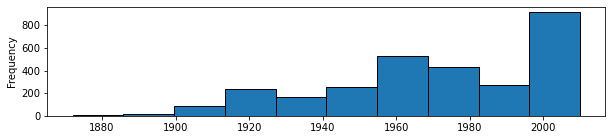

In [18]:
df_train['YearBuilt'].plot(kind='hist', edgecolor='black', figsize=(10, 2)); 

##### Discretiser

In [19]:
#df_train['YearBuilt'] = pd.cut(x=df_train['YearBuilt'], bins=[1700, 1915, 1950, 1990, 2023],
#                    labels=['old++', 'old+', 'old', 'recent'])

df_train['YearBuilt'] = pd.qcut(df_train['YearBuilt'], q=4,
                    labels=['old++', 'old+', 'old', 'recent'])

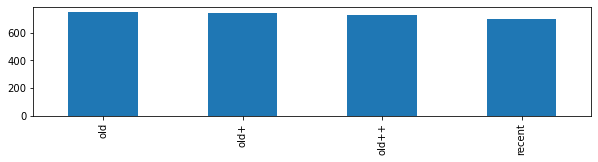

In [20]:
df_train['YearBuilt'].value_counts().plot(kind='bar', figsize=(10, 2));

### YearRemodAdd

<AxesSubplot:ylabel='Frequency'>

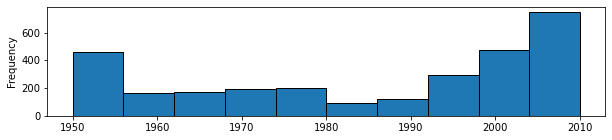

In [21]:
df_train['YearRemodAdd'].plot(kind='hist', edgecolor='black', figsize=(10, 2)) 

In [22]:
#df_train['YearRemodAdd'] = pd.cut(x=df_train['YearRemodAdd'], bins=[1700, 1955, 1995, 2023],
#                    labels=['old+', 'old', 'recent'])

df_train['YearRemodAdd'] = pd.qcut(x=df_train['YearRemodAdd'], q=3,
                    labels=['old+', 'old', 'recent'])

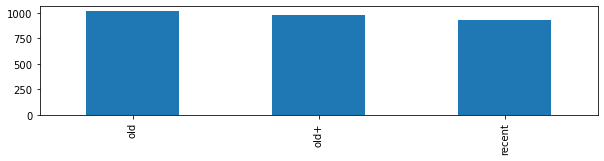

In [23]:
df_train['YearRemodAdd'].value_counts().plot(kind='bar', figsize=(10, 2));

### FullBath

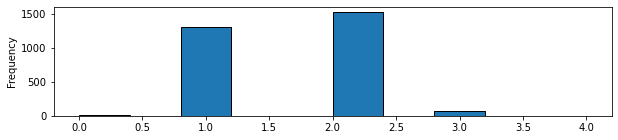

In [24]:
df_train['FullBath'].plot(kind='hist', edgecolor='black', figsize=(10, 2)) ;

### GarageCars

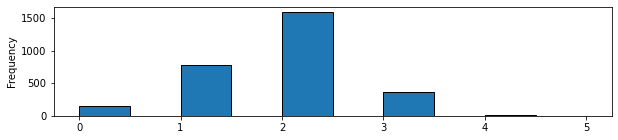

In [25]:
df_train['GarageCars'].plot(kind='hist', edgecolor='black', figsize=(10, 2)) ;

### OverallQual

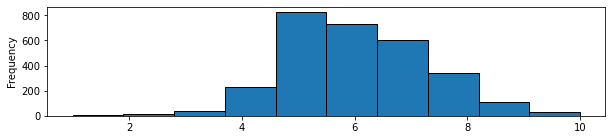

In [26]:
df_train['OverallQual'].plot(kind='hist', edgecolor='black', figsize=(10, 2)) ;

In [27]:
#df_train['OverallQual'] = pd.cut(x=df_train['OverallQual'], bins=[0, 5, 8, 10],
#                    labels=['low', 'middle', 'high'])

df_train['OverallQual'] = pd.qcut(x=df_train['OverallQual'].astype(str).astype(int), q=4, labels=['low', 'middle', 'middle+', 'high'])

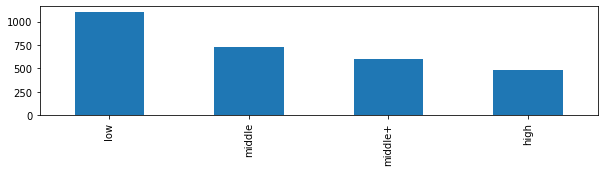

In [28]:
df_train['OverallQual'].value_counts().plot(kind='bar', figsize=(10, 2));

### TotRmsAbvGrd

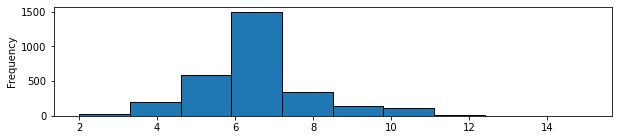

In [29]:
df_train['TotRmsAbvGrd'].plot(kind='hist', edgecolor='black', figsize=(10, 2)) ;

In [30]:
#df_train['TotRmsAbvGrd'] = pd.cut(x=df_train['TotRmsAbvGrd'], bins=[0, 5, 9, 20],
#                    labels=['low', 'middle', 'high'])

df_train['TotRmsAbvGrd'] = pd.qcut(x=df_train['TotRmsAbvGrd'], q=4,
                    labels=['low', 'middle', 'middle+', 'high'])

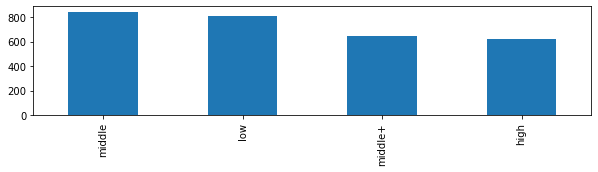

In [31]:
df_train['TotRmsAbvGrd'].value_counts().plot(kind='bar', figsize=(10, 2));

### Fireplaces

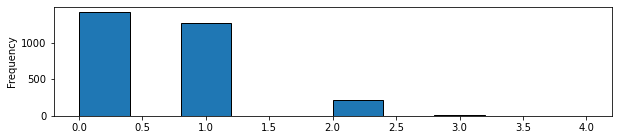

In [32]:
df_train['Fireplaces'].plot(kind='hist', edgecolor='black', figsize=(10, 2)) ;

### 1stFlrSF

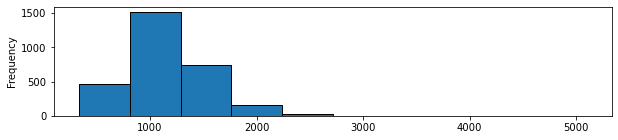

In [33]:
df_train['1stFlrSF'].plot(kind='hist', edgecolor='black', figsize=(10, 2)) ;

In [34]:
df_train.shape

(2919, 13)

### Dichotomisation

YearBuilt YearRemodAdd OverallQual TotRmsAbvGrd GarageCars FullBath

In [35]:
df_YearBuilt_dummies = pd.get_dummies(df_train['YearBuilt'], prefix='YearBuilt')

In [36]:
df_YearRemodAdd_dummies = pd.get_dummies(df_train['YearRemodAdd'], prefix='YearRemodAdd')

In [37]:
df_OverallQual_dummies = pd.get_dummies(df_train['OverallQual'], prefix='OverallQual')

In [38]:
df_TotRmsAbvGrd_dummies = pd.get_dummies(df_train['TotRmsAbvGrd'], prefix='TotRmsAbvGrd')

In [39]:
df_FullBath_dummies = pd.get_dummies(df_train['FullBath'], prefix='FullBath')

In [40]:
df_GarageCars_dummies = pd.get_dummies(df_train['GarageCars'], prefix='GarageCars')

In [41]:
df_Fireplaces_dummies = pd.get_dummies(df_train['Fireplaces'], prefix='Fireplaces')

In [42]:
#df_dummies = df_YearBuilt_dummies.join(df_YearRemodAdd_dummies).join(df_OverallQual_dummies).join(df_TotRmsAbvGrd_dummies).join(df_FullBath_dummies).join(df_GarageCars_dummies)
df_dummies = pd.concat([df_YearBuilt_dummies, 
                        df_YearRemodAdd_dummies,
                        df_OverallQual_dummies,
                        df_TotRmsAbvGrd_dummies,
                        df_FullBath_dummies,
                        df_GarageCars_dummies,
                        df_Fireplaces_dummies], 
                       axis=1)


In [43]:
df_dummies.shape

(2919, 32)

In [44]:
df_train_scaled = df_train[['1stFlrSF','GrLivArea','GarageArea','TotalBsmtSF']]

In [45]:
scaler = preprocessing.StandardScaler().fit(df_train_scaled)
df_train_scaled[df_train_scaled.columns] = pd.DataFrame(scaler.transform(df_train_scaled), index=df_train_scaled.index)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [46]:
df_train = pd.concat([df_dummies, df_train_scaled], axis=1)
df_train.shape

(2919, 36)

In [47]:
df_train.head()

,YearBuilt_old++,YearBuilt_old+,YearBuilt_old,YearBuilt_recent,YearRemodAdd_old+,YearRemodAdd_old,YearRemodAdd_recent,OverallQual_low,OverallQual_middle,OverallQual_middle+,...,GarageCars_5.0,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,Fireplaces_4,1stFlrSF,GrLivArea,GarageArea,TotalBsmtSF
0,0,0,0,1,0,0,1,0,0,1,...,0,1,0,0,0,0,-0.773861,0.413547,0.348900,-0.444328
1,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0.261075,-0.471891,-0.059792,0.477111
2,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,-0.610718,0.563755,0.627553,-0.299076
3,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,-0.506205,0.427382,0.785457,-0.671283
4,0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,-0.037170,1.378042,1.686437,0.211573


In [48]:
#df_train = df_train.fillna(0)

In [49]:
'''
selector = VarianceThreshold(variance_threshold)

selector.fit(df_train)
features = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features
#features
features = [column for column in df_train.columns[features]] #Array of all nonremoved features' names
#features
#Format and Return
df_train = pd.DataFrame(selector.transform(df_train))
df_train.columns = features
'''



"\nselector = VarianceThreshold(variance_threshold)\n\nselector.fit(df_train)\nfeatures = selector.get_support(indices = True) #returns an array of integers corresponding to nonremoved features\n#features\nfeatures = [column for column in df_train.columns[features]] #Array of all nonremoved features' names\n#features\n#Format and Return\ndf_train = pd.DataFrame(selector.transform(df_train))\ndf_train.columns = features\n"

In [50]:
df_test = df_train.tail(1459) #df_train[df_train['SalePrice'] == 0]
#df_test.drop(['SalePrice'], axis = 1, inplace=True)
df_train = df_train.head(1460) #[df_train['SalePrice'] > 0]

print(df_train.shape, df_test.shape)

(1460, 36) (1459, 36)


In [51]:
df_train.shape

(1460, 36)

In [52]:
df_train.head()

,YearBuilt_old++,YearBuilt_old+,YearBuilt_old,YearBuilt_recent,YearRemodAdd_old+,YearRemodAdd_old,YearRemodAdd_recent,OverallQual_low,OverallQual_middle,OverallQual_middle+,...,GarageCars_5.0,Fireplaces_0,Fireplaces_1,Fireplaces_2,Fireplaces_3,Fireplaces_4,1stFlrSF,GrLivArea,GarageArea,TotalBsmtSF
0,0,0,0,1,0,0,1,0,0,1,...,0,1,0,0,0,0,-0.773861,0.413547,0.348900,-0.444328
1,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0.261075,-0.471891,-0.059792,0.477111
2,0,0,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,-0.610718,0.563755,0.627553,-0.299076
3,1,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,-0.506205,0.427382,0.785457,-0.671283
4,0,0,1,0,0,1,0,0,0,0,...,0,0,1,0,0,0,-0.037170,1.378042,1.686437,0.211573


In [53]:
target = df_train_SalePrice
data = df_train

In [54]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.35, random_state = 66) 

In [55]:


print(X_train.shape, X_test.shape)
pca = PCA(n_components = pca_components)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_train.shape, X_test.shape)



(949, 36) (511, 36)
(949, 12) (511, 12)


In [56]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
print(xgboost.__version__)

1.5.2


In [57]:
# create an xgboost regression model
#model_xgbr = XGBRegressor()

# Instantiation
xgb_r = XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 20, seed = 123)
  
# Fitting the model
eval_set = [(X_test, y_test)]
xgb_r.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)
  
# Predict the model
pred = xgb_r.predict(X_test)
  
# RMSE Computation
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE : % f" %(rmse))

[0]	validation_0-rmse:139785.53125
[1]	validation_0-rmse:101457.64062
[2]	validation_0-rmse:76212.57812
[3]	validation_0-rmse:58574.04688
[4]	validation_0-rmse:48118.18359
[5]	validation_0-rmse:41680.48047
[6]	validation_0-rmse:38021.75781
[7]	validation_0-rmse:35523.22656
[8]	validation_0-rmse:34356.30078
[9]	validation_0-rmse:34102.75391
[10]	validation_0-rmse:33677.94531
[11]	validation_0-rmse:33674.36328
[12]	validation_0-rmse:33532.73047
[13]	validation_0-rmse:33275.64062
[14]	validation_0-rmse:33163.80078
[15]	validation_0-rmse:33134.07812
[16]	validation_0-rmse:33078.47656
[17]	validation_0-rmse:33062.68750
[18]	validation_0-rmse:33052.72266
[19]	validation_0-rmse:33021.59375
RMSE :  33021.593038


In [58]:
print("score train :",xgb_r.score(X_train, y_train))
print("score test :", xgb_r.score(X_test, y_test))

score train : 0.9780941238927969
score test : 0.821776528668715


In [59]:
pred = xgb_r.predict(pca.transform(df_test))
#pred = xgb_r.predict(df_test)

df_pred = pd.DataFrame(pred, columns=['SalePrice'])
df_pred.head()

,SalePrice
0,123047.335938
1,144557.203125
2,178901.375000
3,176882.500000
4,195567.828125


In [60]:
df_pred = df_test_Id.join(df_pred)

df_pred.shape

(1459, 2)

In [61]:
df_pred.to_csv('./submission/model_xgb_r.csv', index=False)